# Model Development

In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [2]:
image_dir = 'Data2/Dataset/'
annotation_dir = 'Data2/Annotations'

In [3]:
def add_padding_and_resize(img, target_width, target_height):
    height, width = img.shape
    scale = target_height / height
    new_width = int(width * scale)
    pad_width = target_width - new_width

    left_pad = 0
    right_pad = pad_width

    if pad_width > 0:
        img = cv2.copyMakeBorder(img, 0, 0, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_AREA)
    return img

In [4]:
def create_transliteration_mapping(annotation_dir):
    unique_letters = set()
    for annotation_file in os.listdir(annotation_dir):
        with open(os.path.join(annotation_dir, annotation_file), 'r') as file:
            annotation = file.read().strip()
            letters = annotation.split('-')
            unique_letters.update(letters)
    letter_to_index = {letter: i for i, letter in enumerate(sorted(unique_letters), start=1)}
    return letter_to_index


In [5]:

def load_images_and_labels_for_sequences(image_dir, annotation_dir, letter_to_index, img_height=32, img_width=32*9, max_length=10):
    images = []
    labels = []
    for annotation_file in os.listdir(annotation_dir):
        with open(os.path.join(annotation_dir, annotation_file), 'r') as file:
            annotation = file.read().strip()
            filename = annotation_file.replace('.txt', '.png') 
            img_path = os.path.join(image_dir, filename)
            if os.path.exists(img_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = add_padding_and_resize(img, img_width, img_height)
                img = img / 255.0 
                images.append(img.reshape(img_height, img_width, 1)) 
                label_seq = [letter_to_index[letter] for letter in annotation.split('-') if letter in letter_to_index]
                labels.append(label_seq)
    labels_padded = pad_sequences(labels, maxlen=max_length, padding='post')
    labels_one_hot = [to_categorical(label_seq, num_classes=len(letter_to_index) + 1) for label_seq in labels_padded]
    return np.array(images), np.array(labels_one_hot)

In [6]:
from tensorflow.keras import layers, models

def create_model_for_sequences(input_shape, num_classes, max_length):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Dropout(0.25),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.RepeatVector(max_length),
        layers.Bidirectional(layers.LSTM(256, return_sequences=True)),
        layers.Dropout(0.5),
        layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# CRNN Model

# Training -I

In [7]:

max_length = 10 

letter_to_index = create_transliteration_mapping(annotation_dir)
images, labels = load_images_and_labels_for_sequences(image_dir, annotation_dir, letter_to_index, max_length=max_length)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

input_shape = (32, 32*9, 1)  
num_classes = len(letter_to_index) + 1  
model = create_model_for_sequences(input_shape, num_classes, max_length)
# model.summary()

history_crnn = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))


Epoch 1/15
500/500 [==============================] - 40s 49ms/step - loss: 2.6432 - accuracy: 0.3587 - val_loss: 2.6292 - val_accuracy: 0.3640
Epoch 2/15
500/500 [==============================] - 24s 48ms/step - loss: 2.5056 - accuracy: 0.3757 - val_loss: 2.4165 - val_accuracy: 0.3920
Epoch 3/15
500/500 [==============================] - 24s 48ms/step - loss: 2.3447 - accuracy: 0.4047 - val_loss: 2.2414 - val_accuracy: 0.4275
Epoch 4/15
500/500 [==============================] - 24s 48ms/step - loss: 2.1126 - accuracy: 0.4450 - val_loss: 1.9374 - val_accuracy: 0.4858
Epoch 5/15
500/500 [==============================] - 24s 48ms/step - loss: 1.8440 - accuracy: 0.5009 - val_loss: 1.6392 - val_accuracy: 0.5574
Epoch 6/15
500/500 [==============================] - 24s 48ms/step - loss: 1.6039 - accuracy: 0.5598 - val_loss: 1.4530 - val_accuracy: 0.6095
Epoch 7/15
500/500 [==============================] - 24s 48ms/step - loss: 1.4158 - accuracy: 0.6078 - val_loss: 1.2794 - val_accuracy:

# Traning -II

In [10]:

max_length = 10 

letter_to_index = create_transliteration_mapping(annotation_dir)
images, labels = load_images_and_labels_for_sequences(image_dir, annotation_dir, letter_to_index, max_length=max_length)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

input_shape = (32, 32*9, 1)  
num_classes = len(letter_to_index) + 1  
model = create_model_for_sequences(input_shape, num_classes, max_length)
# model.summary()

history_crnn = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
500/500 [==============================] - 27s 50ms/step - loss: 2.6415 - accuracy: 0.3587 - val_loss: 2.7752 - val_accuracy: 0.3572
Epoch 2/20
500/500 [==============================] - 23s 46ms/step - loss: 2.5277 - accuracy: 0.3708 - val_loss: 2.4501 - val_accuracy: 0.3884
Epoch 3/20
500/500 [==============================] - 23s 46ms/step - loss: 2.3763 - accuracy: 0.4021 - val_loss: 2.2131 - val_accuracy: 0.4330
Epoch 4/20
500/500 [==============================] - 23s 46ms/step - loss: 2.1270 - accuracy: 0.4460 - val_loss: 1.8967 - val_accuracy: 0.4976
Epoch 5/20
500/500 [==============================] - 23s 46ms/step - loss: 1.8249 - accuracy: 0.5042 - val_loss: 1.5960 - val_accuracy: 0.5687
Epoch 6/20
500/500 [==============================] - 23s 47ms/step - loss: 1.5557 - accuracy: 0.5711 - val_loss: 1.3850 - val_accuracy: 0.6241
Epoch 7/20
500/500 [==============================] - 23s 47ms/step - loss: 1.3564 - accuracy: 0.6232 - val_loss: 1.2216 - val_accuracy:

# Traning - III

In [7]:

max_length = 10 

letter_to_index = create_transliteration_mapping(annotation_dir)
images, labels = load_images_and_labels_for_sequences(image_dir, annotation_dir, letter_to_index, max_length=max_length)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

input_shape = (32, 32*9, 1)  
num_classes = len(letter_to_index) + 1  
model = create_model_for_sequences(input_shape, num_classes, max_length)
# model.summary()

history_crnn = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
500/500 [==============================] - 32s 47ms/step - loss: 2.6484 - accuracy: 0.3579 - val_loss: 2.5791 - val_accuracy: 0.3619
Epoch 2/30
500/500 [==============================] - 23s 46ms/step - loss: 2.5206 - accuracy: 0.3740 - val_loss: 2.4395 - val_accuracy: 0.3932
Epoch 3/30
500/500 [==============================] - 23s 45ms/step - loss: 2.3665 - accuracy: 0.4050 - val_loss: 2.2303 - val_accuracy: 0.4316
Epoch 4/30
500/500 [==============================] - 23s 46ms/step - loss: 2.1208 - accuracy: 0.4514 - val_loss: 1.9166 - val_accuracy: 0.4975
Epoch 5/30
500/500 [==============================] - 23s 45ms/step - loss: 1.8040 - accuracy: 0.5150 - val_loss: 1.5580 - val_accuracy: 0.5854
Epoch 6/30
500/500 [==============================] - 23s 46ms/step - loss: 1.5225 - accuracy: 0.5850 - val_loss: 1.3416 - val_accuracy: 0.6460
Epoch 7/30
500/500 [==============================] - 23s 46ms/step - loss: 1.3162 - accuracy: 0.6379 - val_loss: 1.2017 - val_accuracy:

# Training - IV


In [7]:

max_length = 10 

letter_to_index = create_transliteration_mapping(annotation_dir)
images, labels = load_images_and_labels_for_sequences(image_dir, annotation_dir, letter_to_index, max_length=max_length)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

input_shape = (32, 32*9, 1)  
num_classes = len(letter_to_index) + 1  
model = create_model_for_sequences(input_shape, num_classes, max_length)
# model.summary()

history_crnn = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
750/750 [==============================] - 48s 51ms/step - loss: 2.5807 - accuracy: 0.3696 - val_loss: 2.4115 - val_accuracy: 0.3948
Epoch 2/20


ResourceExhaustedError: Graph execution error:

OOM when allocating tensor with shape[8914944] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node concat_1_0}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[sequential/bidirectional/forward_lstm/PartitionedCall]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_5411]

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 286, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 143, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 141, 64)       18432     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 141, 64)      256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 13, 141, 64)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 70, 64)       

In [8]:
model.save('OCR_CRNN_Model3.h5')  # Saves the model to a single HDF5 file.

# If you prefer to save in TensorFlow's SavedModel format, you can use:
model.save('OCR_CRNN_model3') 

INFO:tensorflow:Assets written to: OCR_CRNN_model3\assets


INFO:tensorflow:Assets written to: OCR_CRNN_model3\assets


# CNN Model

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def create_cnn_model_for_sequences(input_shape, num_classes, max_sequence_length):
    """Creates a CNN model for sequence prediction without RNNs."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes * max_sequence_length, activation='softmax'),
        layers.Reshape((max_sequence_length, num_classes))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


max_length = 10 

letter_to_index = create_transliteration_mapping(annotation_dir)
images, labels = load_images_and_labels_for_sequences(image_dir, annotation_dir, letter_to_index, max_length=max_length)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

input_shape = (32, 32*9, 1) 
num_classes = len(letter_to_index) + 1 

model_cnn = create_cnn_model_for_sequences(input_shape, num_classes, max_length)
# model_cnn.summary()

history_cnn = model_cnn.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))


Epoch 1/30
500/500 [==============================] - 10s 19ms/step - loss: 2.6021 - accuracy: 0.3693 - val_loss: 2.3800 - val_accuracy: 0.4240
Epoch 2/30
500/500 [==============================] - 9s 19ms/step - loss: 2.2223 - accuracy: 0.4423 - val_loss: 1.8478 - val_accuracy: 0.5439
Epoch 3/30
500/500 [==============================] - 9s 19ms/step - loss: 1.8838 - accuracy: 0.5102 - val_loss: 1.5550 - val_accuracy: 0.6107
Epoch 4/30
500/500 [==============================] - 9s 19ms/step - loss: 1.6888 - accuracy: 0.5529 - val_loss: 1.4149 - val_accuracy: 0.6434
Epoch 5/30
500/500 [==============================] - 9s 19ms/step - loss: 1.5593 - accuracy: 0.5842 - val_loss: 1.3171 - val_accuracy: 0.6636
Epoch 6/30
500/500 [==============================] - 9s 19ms/step - loss: 1.4629 - accuracy: 0.6082 - val_loss: 1.2650 - val_accuracy: 0.6827
Epoch 7/30
500/500 [==============================] - 9s 19ms/step - loss: 1.3787 - accuracy: 0.6312 - val_loss: 1.2170 - val_accuracy: 0.691

In [10]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 286, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 143, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 141, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 70, 64)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 68, 128)        73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 34, 128)      

In [14]:
model_cnn.save('OCR_CNN_Model2.h5')  # Saves the model to a single HDF5 file.

# If you prefer to save in TensorFlow's SavedModel format, you can use:
model_cnn.save('OCR_CNN_model2') 

INFO:tensorflow:Assets written to: OCR_CNN_model2\assets


INFO:tensorflow:Assets written to: OCR_CNN_model2\assets


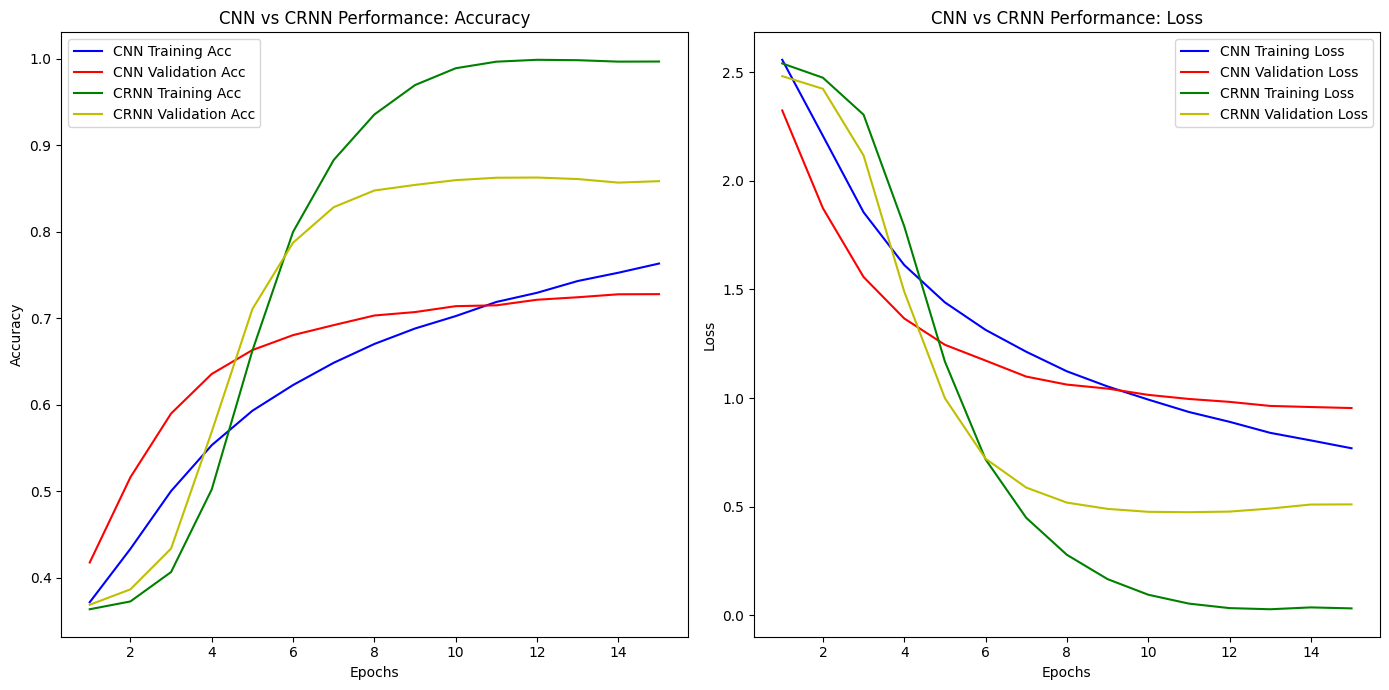

In [18]:
import matplotlib.pyplot as plt

def plot_model_performance(history_cnn, history_crnn, title='CNN vs CRNN Performance'):
    epochs = range(1, len(history_cnn.history['accuracy']) + 1)

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_cnn.history['accuracy'], 'b-', label='CNN Training Acc')
    plt.plot(epochs, history_cnn.history['val_accuracy'], 'r-', label='CNN Validation Acc')
    plt.plot(epochs, history_crnn.history['accuracy'], 'g-', label='CRNN Training Acc')
    plt.plot(epochs, history_crnn.history['val_accuracy'], 'y-', label='CRNN Validation Acc')
    plt.title(title + ': Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_cnn.history['loss'], 'b-', label='CNN Training Loss')
    plt.plot(epochs, history_cnn.history['val_loss'], 'r-', label='CNN Validation Loss')
    plt.plot(epochs, history_crnn.history['loss'], 'g-', label='CRNN Training Loss')
    plt.plot(epochs, history_crnn.history['val_loss'], 'y-', label='CRNN Validation Loss')
    plt.title(title + ': Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_model_performance(history_cnn, history_crnn, title='CNN vs CRNN Performance')


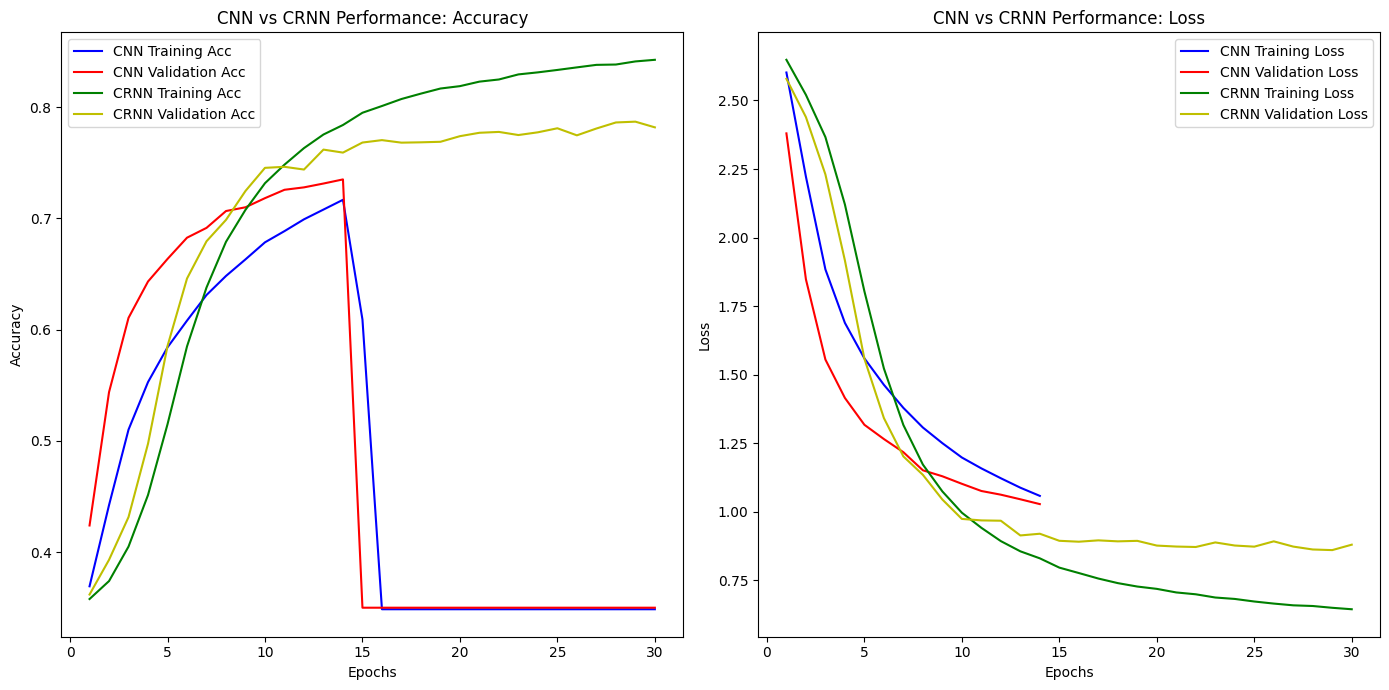

In [15]:
import matplotlib.pyplot as plt

def plot_model_performance(history_cnn, history_crnn, title='CNN vs CRNN Performance'):
    epochs = range(1, len(history_cnn.history['accuracy']) + 1)

    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_cnn.history['accuracy'], 'b-', label='CNN Training Acc')
    plt.plot(epochs, history_cnn.history['val_accuracy'], 'r-', label='CNN Validation Acc')
    plt.plot(epochs, history_crnn.history['accuracy'], 'g-', label='CRNN Training Acc')
    plt.plot(epochs, history_crnn.history['val_accuracy'], 'y-', label='CRNN Validation Acc')
    plt.title(title + ': Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_cnn.history['loss'], 'b-', label='CNN Training Loss')
    plt.plot(epochs, history_cnn.history['val_loss'], 'r-', label='CNN Validation Loss')
    plt.plot(epochs, history_crnn.history['loss'], 'g-', label='CRNN Training Loss')
    plt.plot(epochs, history_crnn.history['val_loss'], 'y-', label='CRNN Validation Loss')
    plt.title(title + ': Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_model_performance(history_cnn, history_crnn, title='CNN vs CRNN Performance')


# testing

In [32]:

def index_to_letter(index_mapping):
    """Create a reverse mapping from index to letter."""
    return {index: letter for letter, index in index_mapping.items()}

def decode_predictions(predictions, index_mapping):
    reverse_mapping = index_to_letter(index_mapping)
    return '-'.join([reverse_mapping.get(index, '') for index in predictions])

def process_annotation(annotation_file):
    with open(annotation_file, 'r') as file:
        annotation = file.read().strip()
    letters = annotation.split('-')
    return [letter_to_index[letter] for letter in letters if letter in letter_to_index]


image_path = 'Data/Dataset/word_1.png'
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

target_width, target_height = 32*9, 32 

img_preprocessed = add_padding_and_resize(img, target_width, target_height)


cnn_prediction = cnn_model.predict(np.expand_dims(img_preprocessed, axis=0))
crnn_prediction = crnn_model.predict(np.expand_dims(img_preprocessed, axis=0))


decoded_cnn_prediction = decode_predictions([np.argmax(cnn_prediction)], letter_to_index)
decoded_crnn_prediction = decode_predictions(np.argmax(crnn_prediction, axis=-1)[0], letter_to_index)


annotation_file = 'Data/Annotations/word_1.txt'
ground_truth = process_annotation(annotation_file)
decoded_ground_truth = decode_predictions(ground_truth, letter_to_index)


print("Ground Truth:", decoded_ground_truth)
print("CNN Prediction:", decoded_cnn_prediction)
print("CRNN Prediction:", decoded_crnn_prediction)


1/1 [==============================] - 0s 322ms/step
Ground Truth: jha-kha-9-ma-ja-yaw-motosaw-pha
CNN Prediction: 
CRNN Prediction: chhya-chhya-chhya-chhya-chhya-chhya-chhya-chhya-chhya-chhya


In [16]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


def add_padding_and_resize(img, target_width, target_height):
    height, width = img.shape
    scale = target_height / height
    new_width = int(width * scale)
    pad_width = target_width - new_width

    
    if pad_width > 0:
        img = cv2.copyMakeBorder(img, 0, 0, 0, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    img = cv2.resize(img, (target_width, target_height), interpolation=cv2.INTER_AREA)
    return img


def preprocess_image(image_path, img_height=32, img_width=32*9):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = add_padding_and_resize(img, img_width, img_height)
    img = img / 255.0 
    img = img.reshape(1, img_height, img_width, 1)  
    return img

def create_index_to_letter_mapping(letter_to_index):
    return {index: letter for letter, index in letter_to_index.items()}


cnn_model = load_model('OCR_CNN_model.h5')
crnn_model = load_model('OCR_CRNN_model.h5')



In [17]:
import os


def create_transliteration_mapping(annotation_dir):
    unique_letters = set()
    for annotation_file in os.listdir(annotation_dir):
        with open(os.path.join(annotation_dir, annotation_file), 'r') as file:
            annotation = file.read().strip()
            letters = annotation.split('-')
            unique_letters.update(letters)
    letter_to_index = {letter: i for i, letter in enumerate(sorted(unique_letters), start=1)}
    return letter_to_index

annotation_dir = 'Data/Annotations'


letter_to_index = create_transliteration_mapping(annotation_dir)


index_to_letter = {index: letter for letter, index in letter_to_index.items()}


In [18]:
def model_predict(model, preprocessed_image):
    prediction = model.predict(preprocessed_image)
    return np.argmax(prediction, axis=-1)

def predictions_to_text(predictions, index_to_letter):
    return '-'.join([index_to_letter.get(index, '') for index in predictions[0] if index > 0])


In [19]:
def load_annotation(annotation_path):
    with open(annotation_path, 'r') as file:
        annotation = file.read().strip()
    return annotation

In [20]:
image_path = 'Data/Dataset/word_200.png'
annotation_path = 'Data/Annotations/word_200.txt'


preprocessed_image = preprocess_image(image_path)


cnn_predictions = model_predict(cnn_model, preprocessed_image)
crnn_predictions = model_predict(crnn_model, preprocessed_image)


cnn_text_prediction = predictions_to_text(cnn_predictions, index_to_letter)
crnn_text_prediction = predictions_to_text(crnn_predictions, index_to_letter)


def load_annotation(annotation_path):
    with open(annotation_path, 'r') as file:
        annotation = file.read().strip()
    return annotation

actual_annotation = load_annotation(annotation_path)


print(f"Actual Annotation: {actual_annotation}")
print(f"CNN Prediction: {cnn_text_prediction}")
print(f"CRNN Prediction: {crnn_text_prediction}")


1/1 [==============================] - 1s 645ms/step
Actual Annotation: ल-त्र-क्ष-क्ष-ख-५-क्ष-ग
CNN Prediction: 
CRNN Prediction: ल-त्र-क्ष-क्ष-ख-५-क्ष-ग


1/1 [==============================] - 0s 23ms/step


C:\Users\Asus\AppData\Local\Temp\ipykernel_17808\2997441598.py:61: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from current font.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_17808\2997441598.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_17808\2997441598.py:61: UserWarning: Glyph 2338 (\N{DEVANAGARI LETTER DDHA}) missing from current font.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_17808\2997441598.py:61: UserWarning: Glyph 2358 (\N{DEVANAGARI LETTER SHA}) missing from current font.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_17808\2997441598.py:61: UserWarning: Glyph 2415 (\N{DEVANAGARI DIGIT NINE}) missing from current font.
  plt.tight_layout()
C:\Users\Asus\AppData\Local\Temp\ipykernel_17808\2997441598.py:61: UserWarning: Glyph 2343 (\N{DEVANAGARI LETTER DHA}) missing from current font.
  plt.tight_layout()
C:\Us

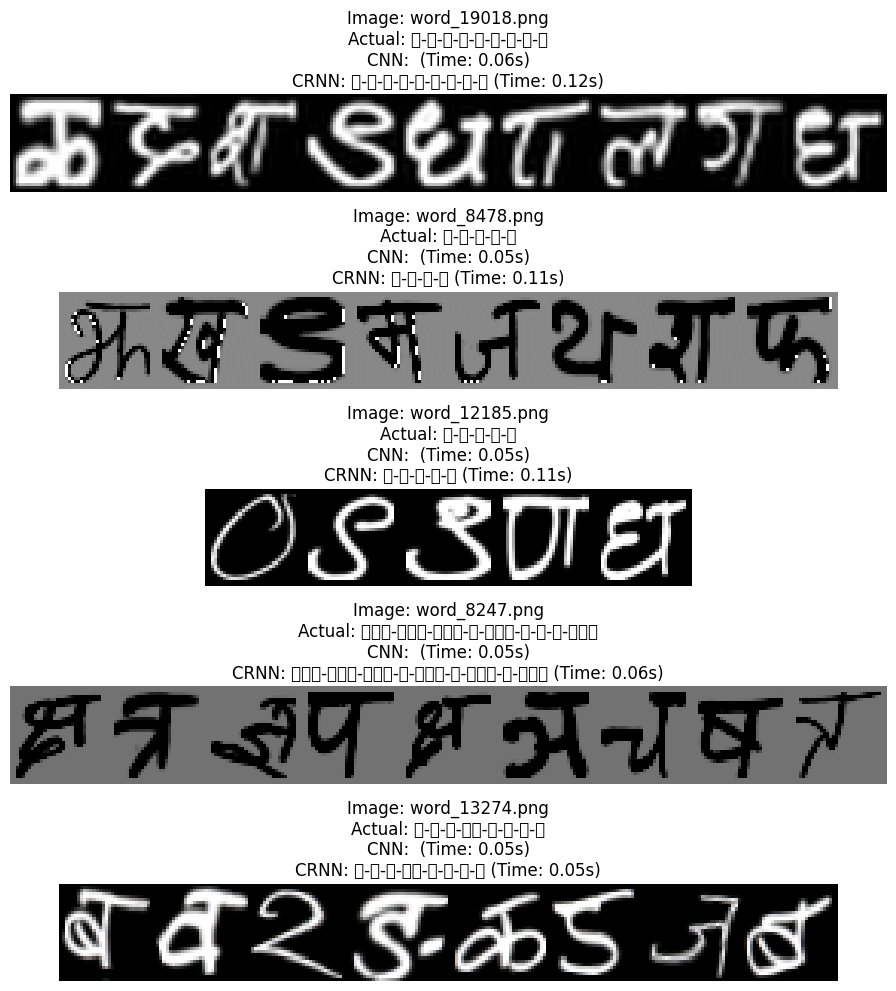

In [21]:
import os
import time
import matplotlib.pyplot as plt
import random

dataset_dir = 'Data/Dataset'
annotation_dir = 'Data/Annotations'

image_names = []
actual_annotations = []
cnn_predictions_list = []
crnn_predictions_list = []
cnn_inference_times = []
crnn_inference_times = []


all_images = [f for f in os.listdir(dataset_dir) if os.path.isfile(os.path.join(dataset_dir, f))]


random_images = random.sample(all_images, 5)


plt.figure(figsize=(15, 10)) 
for index, image_name in enumerate(random_images):
    image_path = os.path.join(dataset_dir, image_name)
    original_image = plt.imread(image_path) 
    preprocessed_image = preprocess_image(image_path)
    
    
    start_time = time.time()
    cnn_predictions = model_predict(cnn_model, preprocessed_image)
    cnn_inference_time = time.time() - start_time
    
    
    start_time = time.time()
    crnn_predictions = model_predict(crnn_model, preprocessed_image)
    crnn_inference_time = time.time() - start_time 
    
    
    cnn_text_prediction = predictions_to_text(cnn_predictions, index_to_letter)
    crnn_text_prediction = predictions_to_text(crnn_predictions, index_to_letter)
    annotation_path = os.path.join(annotation_dir, image_name.replace('.png', '.txt'))
    actual_annotation = load_annotation(annotation_path)
    
    
    image_names.append(image_name)
    actual_annotations.append(actual_annotation)
    cnn_predictions_list.append(cnn_text_prediction)
    crnn_predictions_list.append(crnn_text_prediction)
    cnn_inference_times.append(cnn_inference_time)
    crnn_inference_times.append(crnn_inference_time)
    
    
    plt.subplot(5, 1, index + 1) 
    plt.imshow(original_image)
    plt.title(f"Image: {image_name}\nActual: {actual_annotation}\nCNN: {cnn_text_prediction} (Time: {cnn_inference_time:.2f}s)\nCRNN: {crnn_text_prediction} (Time: {crnn_inference_time:.2f}s)")
    plt.axis('off')



plt.tight_layout()
plt.show()
